In [1]:
# Imports

import math, pickle, os, copy, sys, scipy.io, json, datetime

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from numpy import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Add the project directory to the path
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from samples.data_sim import PVDataset

#### FL
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from trainer import Trainer
from models import *
from metrics import mse

# Set the random seed
random_seed = 46
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'mps'

In [12]:
# Generate data for 1 client

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

NUM_CLIENTS=1

city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 0, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data()

time_series = env_dict['train_scenarios']['1y']['time_series'][0]

# Remove nights
time_series = time_series[time_series['hour_day'].isin(np.arange(hour_begin, hour_end))]

# Add column day_of_month using column time
time_series['day'] = time_series['time'].dt.day

# Reorder columns
time_series = time_series[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]
time_series.sample(3)

[INFO] generating data for Lausanne


,time,year,month,day,hour_day,H_sun,T2m,WS10m,hourofd_x,hourofd_y,dayofy_x,dayofy_y,station_irrad_direct_prev,station_irrad_diffuse_prev,lag 1,target
80342,2014-03-02 15:10:00,2014,3,2,15,19.74,15.806133,1.322021,-7.071068e-01,-0.707107,0.867456,0.497513,0.000000,83.888610,11.813488,24.716404
47821,2010-06-16 14:10:00,2010,6,16,14,51.01,12.308159,0.666466,-5.000000e-01,-0.866025,0.263665,-0.964614,0.000000,78.590382,10.458863,13.134210
62459,2012-02-16 12:10:00,2012,2,16,12,30.92,5.132578,2.181787,1.224647e-16,-1.000000,0.723644,0.690173,2.890523,171.632869,26.479149,17.932810


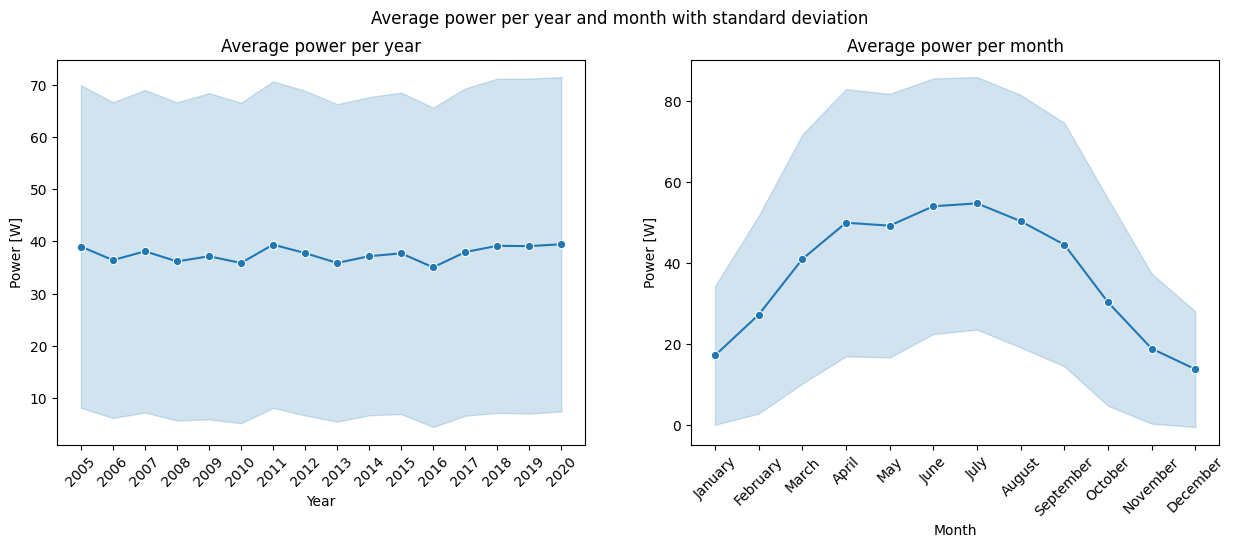

In [40]:
# plot with errorbar the avg and std of the target for each year
plt.figure(figsize=(15, 5))
plt.suptitle('Average power per year and month with standard deviation')
plt.subplot(1, 2, 1)
sns.lineplot(x='year', y='target', data=time_series, ci='sd', marker='o')
plt.title('Average power per year')
plt.ylabel('Power [W]')
plt.xlabel('Year')
plt.xticks(np.arange(2005, 2021), rotation=45)
plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='target', data=time_series, ci='sd', marker='o')
plt.xlabel('Month')
plt.xticks(np.arange(1, 13), [months_name[i] for i in np.arange(1, 13)], rotation=45)   
plt.ylabel('Power [W]')
plt.title('Average power per month')
plt.show()

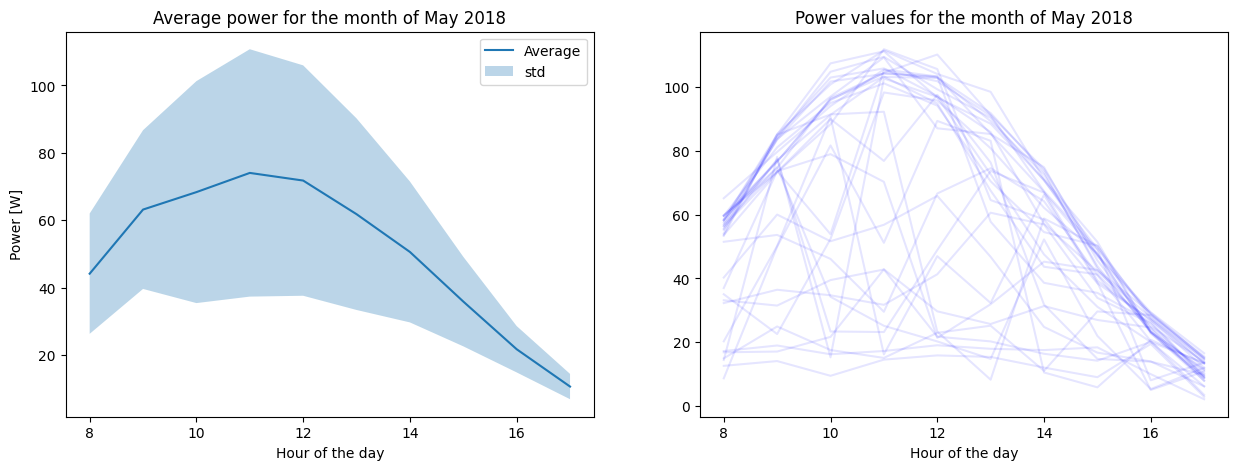

In [10]:
selected_year = 2018
selected_month = 5

power_values = time_series[(time_series.year == selected_year) & (time_series.month == selected_month)]['target'].values
time_values = time_series[(time_series.year == selected_year) & (time_series.month == selected_month)]['hour_day'].values

# Plot the power values for a specific month
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), label='Average')
plt.fill_between(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0) - np.std(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0) + np.std(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), alpha=0.3, label='std')
plt.title('Average power for the month of {} {}'.format(months_name[selected_month], selected_year))
plt.xlabel('Hour of the day')
plt.ylabel('Power [W]')
plt.legend()
plt.savefig('power_month.png')
plt.subplot(1,2,2)
plt.plot(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), power_values.reshape(-1, (hour_end-hour_begin)).T, color='blue', alpha=0.1)
plt.title('Power values for the month of {} {}'.format(months_name[selected_month], selected_year))
plt.xlabel('Hour of the day')
plt.show()

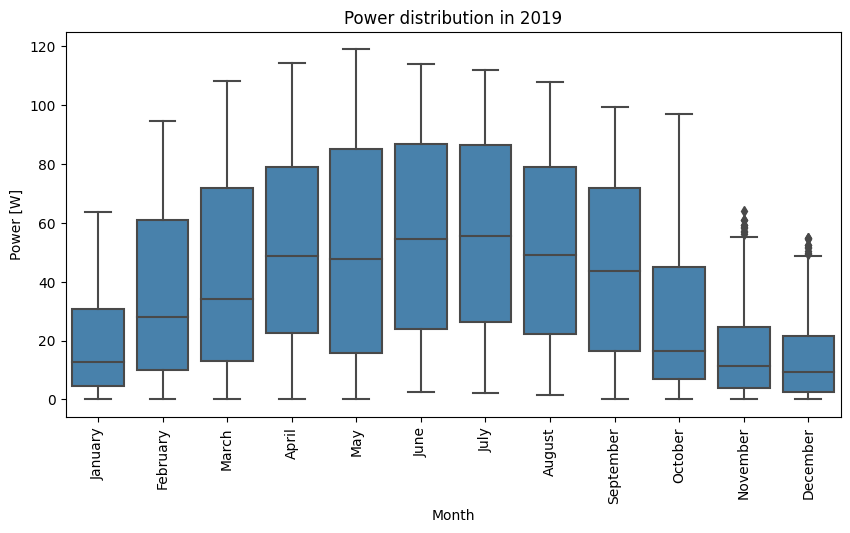

In [7]:
# plot the average power for each month of a year
year = 2019
# sns.set_theme(style="ticks")
# sns.set_context('talk')

fig, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='month', y='target', data=time_series[time_series.year==year], color='#3883bb')
plt.ylabel('Power [W]')
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=90)
plt.xlabel('Month')
plt.title('Power distribution in {}'.format(year))
plt.show()

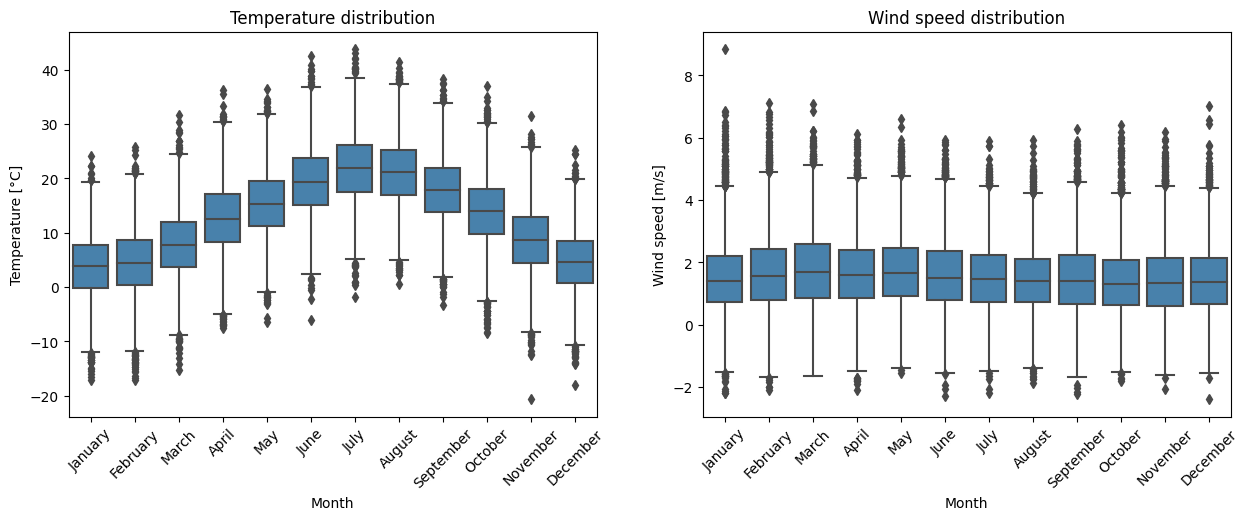

In [90]:
# # Show the average temperature for each month with std
# fig, ax = plt.subplots(figsize=(10, 5))
# fig = sns.boxplot(x='month', y='T2m', data=time_series[0], color='#3883bb')
# plt.ylabel('Temperature [°C]')
# plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45)
# plt.xlabel('Month')
# plt.title('Temperature distribution')
# plt.show()

# # Show the average Wind speed for each month with std
# fig, ax = plt.subplots(figsize=(10, 5))
# fig = sns.boxplot(x='month', y='WS10m', data=time_series[0], color='#3883bb')
# plt.ylabel('Wind speed [m/s]')
# plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45)
# plt.xlabel('Month')
# plt.title('Wind speed distribution')
# plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.boxplot(x='month', y='T2m', data=time_series[0], color='#3883bb')
plt.ylabel('Temperature [°C]')
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45)
plt.xlabel('Month')
plt.title('Temperature distribution')

plt.subplot(1,2,2)
sns.boxplot(x='month', y='WS10m', data=time_series[0], color='#3883bb')
plt.ylabel('Wind speed [m/s]')
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45)
plt.xlabel('Month')
plt.title('Wind speed distribution')
plt.show()


### 1. Visualize the data for multiple households

In [17]:
# Generate data

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

NUM_CLIENTS=5

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 5, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data()

time_series = []

for client_ in range(NUM_CLIENTS):
    time_series_ = env_dict['train_scenarios']['1y']['time_series'][client_]

    # Remove nights
    time_series_ = time_series_[time_series_['hour_day'].isin(np.arange(hour_begin, hour_end))]

    # Add column day_of_month using column time
    time_series_['day'] = time_series_['time'].dt.day

    # Reorder columns
    time_series_ = time_series_[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]

    time_series.append(time_series_)

In [18]:
# print the information about clients_config 
for client_ in range(NUM_CLIENTS):
    print(f'Client {client_} - Tilt: {env_dict["clients_config"]["tilt"][client_]} - Azimuth: {env_dict["clients_config"]["azimuth"][client_]} - Altitude: {env_dict["clients_config"]["altitude"][client_]}')
print()    
for client_ in range(NUM_CLIENTS):
    print(f'Client {client_} - Module: {env_dict["clients_config"]["module_name"][client_]} - Inverter: {env_dict["clients_config"]["inverter_name"][client_]}')

Client 0 - Tilt: 53.23641253632977 - Azimuth: 177.2499192740808 - Altitude: 482.0563746625458
Client 1 - Tilt: 50.518557736792964 - Azimuth: 178.3656910522271 - Altitude: 529.793270227505
Client 2 - Tilt: 47.37968572955134 - Azimuth: 180.38637807043793 - Altitude: 432.9362756301612
Client 3 - Tilt: 48.25312520064515 - Azimuth: 182.8508320675445 - Altitude: 478.86008666124104
Client 4 - Tilt: 47.242774481773324 - Azimuth: 179.88433785611366 - Altitude: 562.8236986108545

Client 0 - Module: Advent_Solar_AS160___2006_ - Inverter: ABB__MICRO_0_25_I_OUTD_US_208__208V_
Client 1 - Module: Advent_Solar_Ventura_210___2008_ - Inverter: ABB__MICRO_0_25_I_OUTD_US_240__240V_
Client 2 - Module: Advent_Solar_Ventura_215___2009_ - Inverter: ABB__MICRO_0_3_I_OUTD_US_208__208V_
Client 3 - Module: Aleo_S03_160__2007__E__ - Inverter: ABB__MICRO_0_3_I_OUTD_US_240__240V_
Client 4 - Module: Aleo_S03_165__2007__E__ - Inverter: ABB__MICRO_0_3HV_I_OUTD_US_208__208V_


In [19]:
# for each client, normalize the column target by month
time_series_norm = []
for client_ in range(NUM_CLIENTS):
    time_series_norm_ = time_series[client_].copy()
    time_series_norm_['target'] = time_series_norm_.groupby(['year', 'month'])['target'].transform(lambda x: (x - x.mean()) / x.std())
    time_series_norm.append(time_series_norm_)

In [20]:
time_series_norm[0]['target']

7        -0.761108
8         0.195722
9         1.049125
10        1.840377
11        1.734295
            ...   
140244    0.799133
140245   -0.620841
140246   -0.875051
140247   -0.955330
140248   -0.955330
Name: target, Length: 58440, dtype: float64

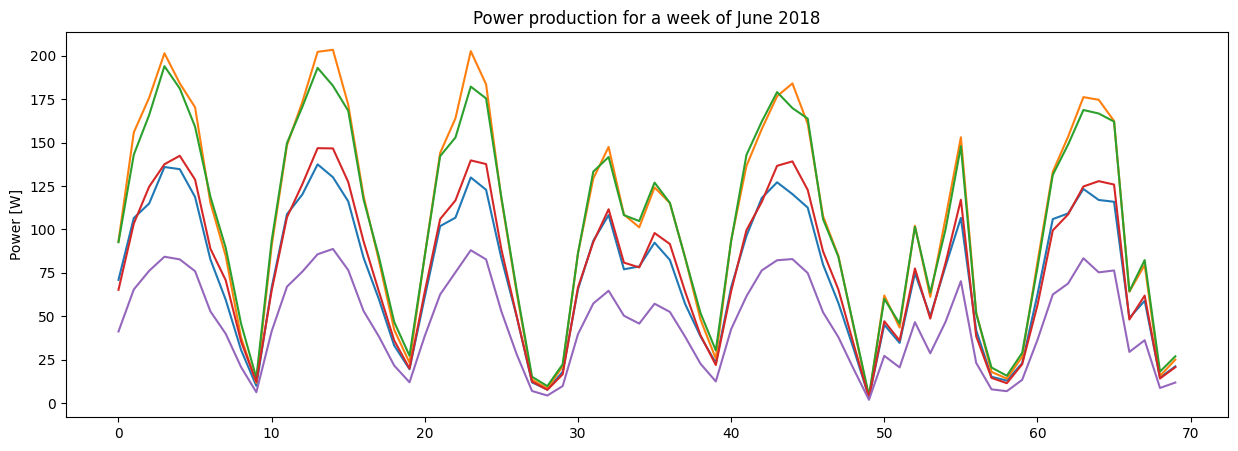

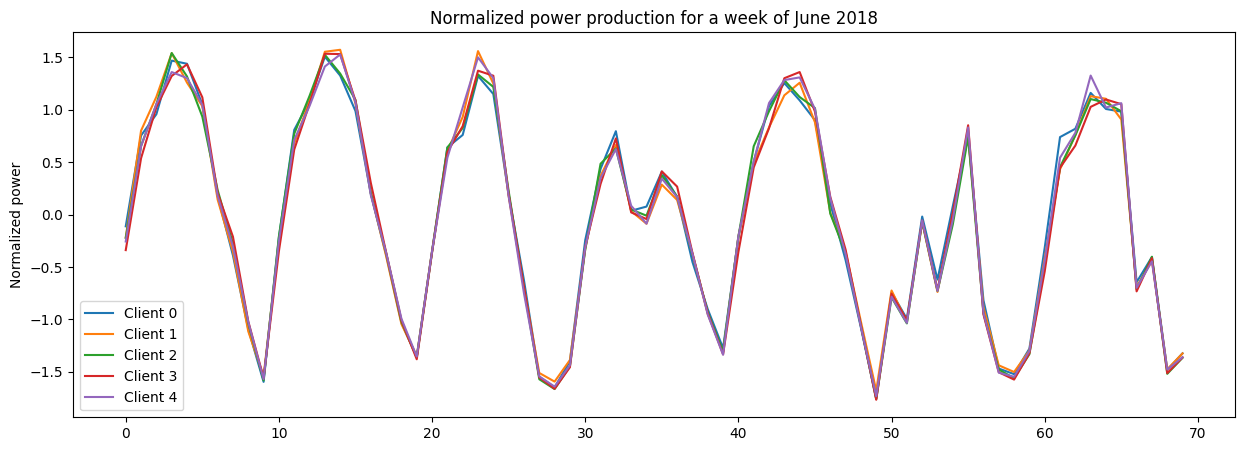

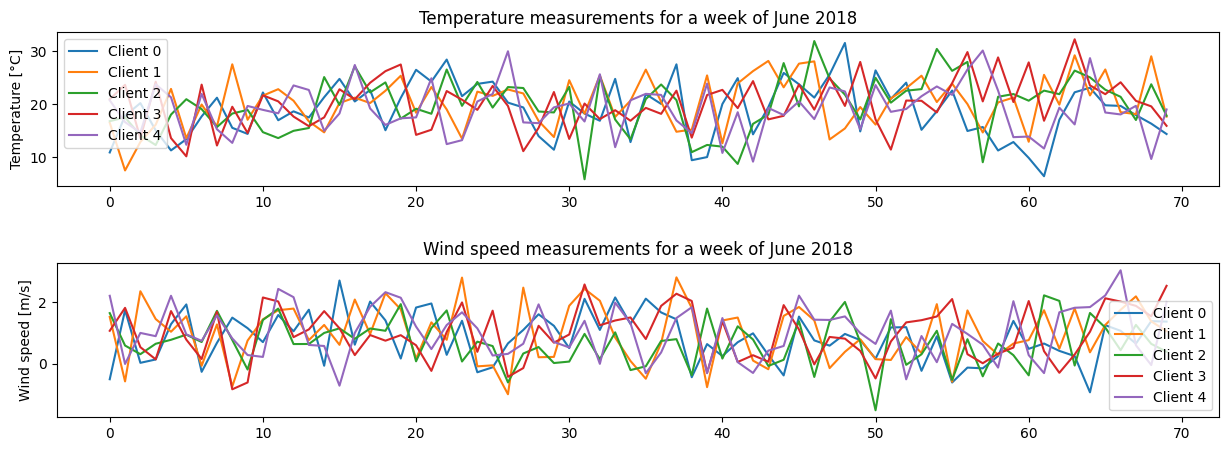

In [21]:
year = 2018
month = 6

plt.figure(figsize=(15, 5))
plt.ylabel('Power [W]')
plt.title('Power production for a week of {} {}'.format(months_name[month], year))

for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['target'].values, label='Client {}'.format(client_))
    
# add normalized version

plt.figure(figsize=(15, 5))
plt.ylabel('Normalized power')
plt.title('Normalized power production for a week of {} {}'.format(months_name[month], year))

for client_ in range(NUM_CLIENTS):
    time_series_client = time_series_norm[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['target'].values, label='Client {}'.format(client_))
    


    
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
plt.ylabel('Temperature [°C]')
plt.title('Temperature measurements for a week of {} {}'.format(months_name[month], year))

for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['T2m'].values, label='Client {}'.format(client_))
    
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.ylabel('Wind speed [m/s]')
plt.title('Wind speed measurements for a week of {} {}'.format(months_name[month], year))

for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['WS10m'].values, label='Client {}'.format(client_))
    
plt.legend(loc='best')
plt.show()